In [ ]:
!pip install backtesting stable-baselines3 pyyaml h5py  -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.1/190.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

warnings.filterwarnings("ignore")

from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, LSTM, SimpleRNN
from tensorflow.keras.models import load_model

import gym
from gym import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
# from trading_env import ForexTradingEnv

In [ ]:
daily_df = pd.read_csv('EURUSD_D1', delimiter=';')
df_15min = pd.read_csv('EURUSD_15min', delimiter=';')

df = daily_df.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1747 entries, 0 to 1746
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1747 non-null   int64  
 1   Time         1747 non-null   object 
 2   Open         1747 non-null   float64
 3   High         1747 non-null   float64
 4   Low          1747 non-null   float64
 5   Close        1747 non-null   float64
 6   Volume       1747 non-null   int64  
 7   Real_volume  1747 non-null   int64  
 8   Spread       1747 non-null   int64  
 9   timeframe    1747 non-null   object 
 10  symbol       1747 non-null   object 
dtypes: float64(4), int64(4), object(3)
memory usage: 150.3+ KB


In [ ]:
df_info = pd.DataFrame(df.dtypes, columns=["Tipo de dato"])
df_info["Valores no nulos"] = df.count()
df_info["Valores nulos"] = df.isnull().sum()
df_info["Porcentaje de nulos"] = (df.isnull().sum() / len(df)) * 100

display(df_info)

,Tipo de dato,Valores no nulos,Valores nulos,Porcentaje de nulos
Unnamed: 0,int64,1747,0,0.0
Time,object,1747,0,0.0
Open,float64,1747,0,0.0
High,float64,1747,0,0.0
Low,float64,1747,0,0.0
Close,float64,1747,0,0.0
Volume,int64,1747,0,0.0
Real_volume,int64,1747,0,0.0
Spread,int64,1747,0,0.0
timeframe,object,1747,0,0.0


In [ ]:
df.describe()

,Open,High,Low,Close,Volume,Real_volume,Spread
count,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.0,1747.000000
mean,1.284026,1.289570,1.278978,1.284287,88222.153978,0.0,0.027476
std,0.059165,0.058350,0.059919,0.059108,38841.656262,0.0,0.163512
min,1.068470,1.083780,1.036440,1.068550,18265.000000,0.0,0.000000
25%,1.247180,1.251905,1.242220,1.247285,62913.000000,0.0,0.000000
50%,1.280800,1.286410,1.276280,1.281330,78833.000000,0.0,0.000000
75%,1.318745,1.324480,1.313265,1.319190,103244.000000,0.0,0.000000
max,1.420530,1.424860,1.416400,1.420620,305760.000000,0.0,1.000000


In [ ]:
df['Time'] = pd.to_datetime(df['Time'])
del df['Unnamed: 0']
del df['Real_volume']
del df['Spread']
del df['timeframe']
del df['symbol']

In [ ]:
df.isnull().sum()

Time      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [ ]:
print(f'Fecha máxima: {df["Time"].max()}')
print(f'Fecha mínima: {df["Time"].min()}')

Fecha máxima: 2025-01-23 00:00:00
Fecha mínima: 2018-05-01 00:00:00


# Análisis exploratorio del conjunto de datos

<Figure size 1400x1000 with 0 Axes>

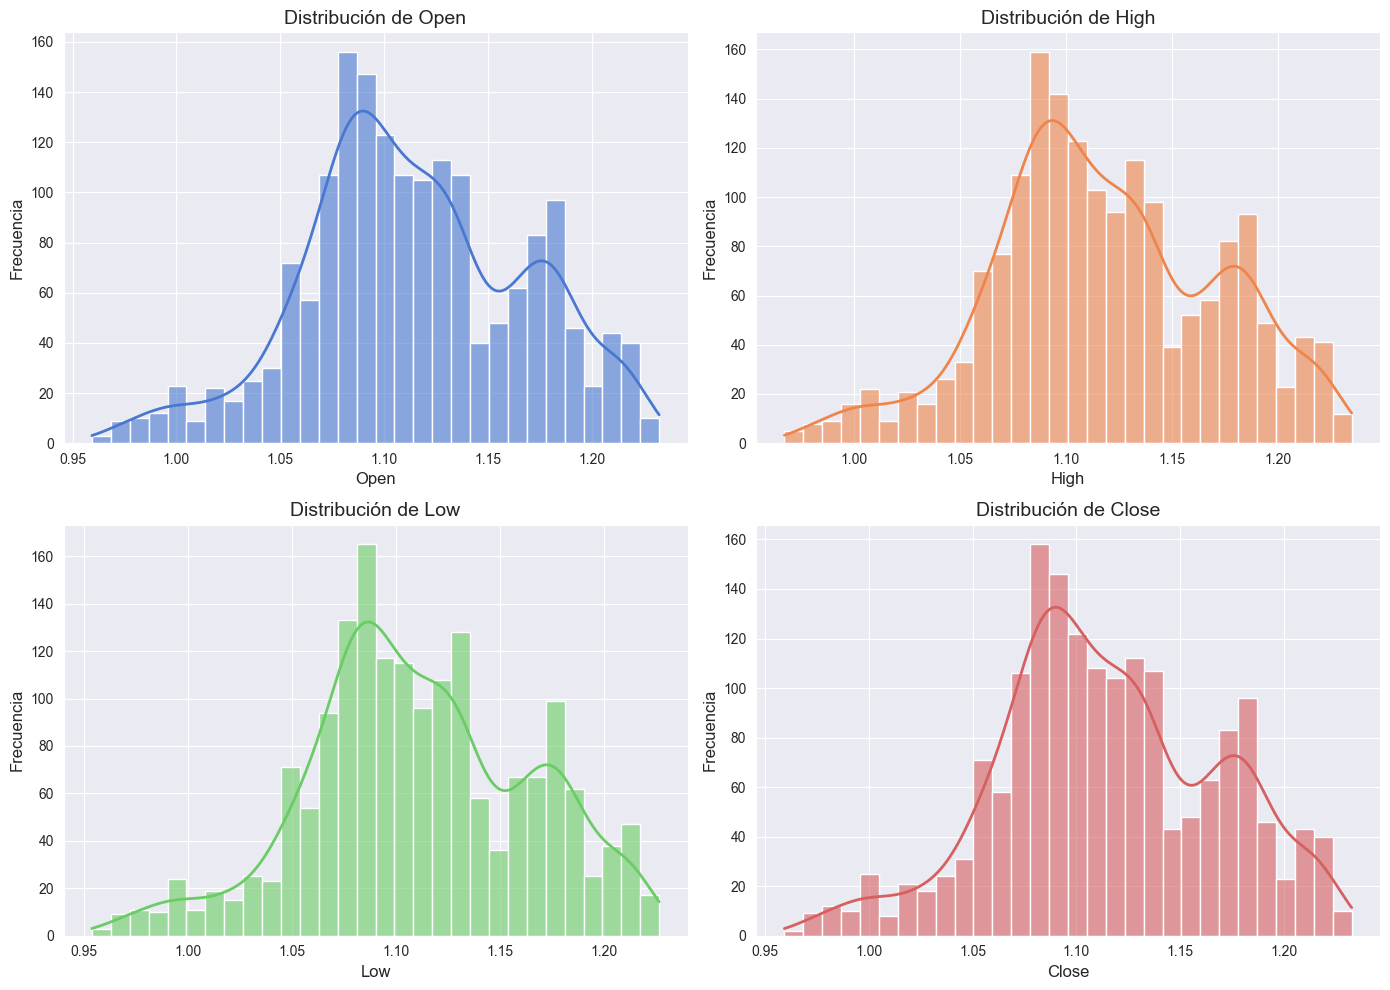

In [ ]:
plt.figure(figsize=(14, 10))

variables = ['Open', 'High', 'Low', 'Close']
color_palette = sns.color_palette("muted", len(variables))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, var in enumerate(variables):
    sns.histplot(df[var], kde=True, bins=30, color=color_palette[i], alpha=0.6,
                 line_kws={'color': 'red', 'lw': 2}, ax=axes[i])
    axes[i].set_title(f'Distribución de {var}', fontsize=14)
    axes[i].set_xlabel(var, fontsize=12)
    axes[i].set_ylabel('Frecuencia', fontsize=12)

plt.tight_layout()
plt.show()


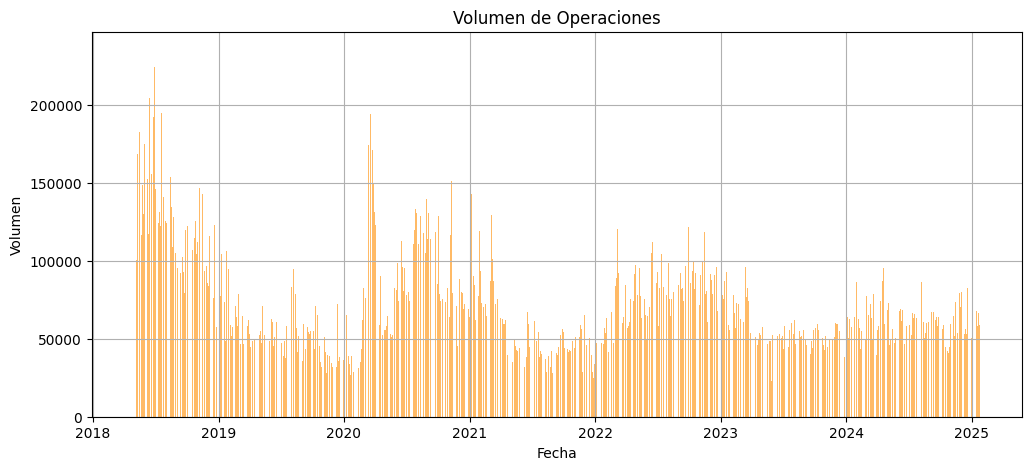

In [ ]:
def plot_volume(df):
    """Grafico del volumen negociado en el tiempo."""
    plt.figure(figsize=(12, 5))
    plt.bar(df['Time'], df['Volume'], color='darkorange', alpha=0.6)
    plt.xlabel("Fecha")
    plt.ylabel("Volumen")
    plt.title(f"Volumen de Operaciones")
    plt.grid()
    plt.show()

plot_volume(df)

### Media móvil

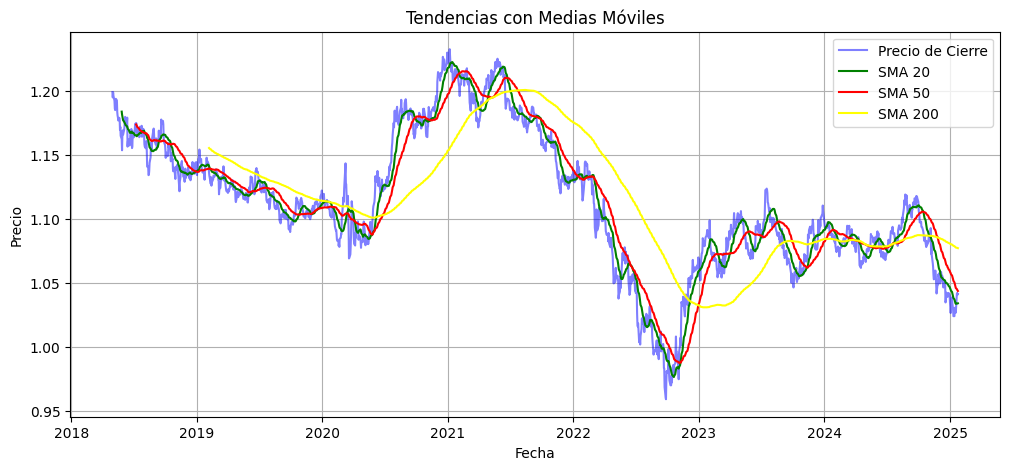

In [ ]:
def plot_moving_averages(df, short_window=20, long_window=50):
    """Grafico de medias móviles de corto y largo plazo."""
    df[f'SMA_{short_window}'] = df['Close'].rolling(window=short_window).mean()
    df[f'SMA_{long_window}'] = df['Close'].rolling(window=long_window).mean()
    df[f'SMA_200'] = df['Close'].rolling(window=200).mean()

    plt.figure(figsize=(12, 5))
    plt.plot(df['Time'], df['Close'], label='Precio de Cierre', color='blue', alpha=0.5)
    plt.plot(df['Time'], df[f'SMA_{short_window}'], label=f'SMA {short_window}', color='green')
    plt.plot(df['Time'], df[f'SMA_{long_window}'], label=f'SMA {long_window}', color='red')
    plt.plot(df['Time'], df[f'SMA_200'], label=f'SMA 200', color='yellow')
    plt.xlabel("Fecha")
    plt.ylabel("Precio")
    plt.title(f"Tendencias con Medias Móviles")
    plt.legend()
    plt.grid()
    plt.show()

plot_moving_averages(df)

### Media móvil exponencial

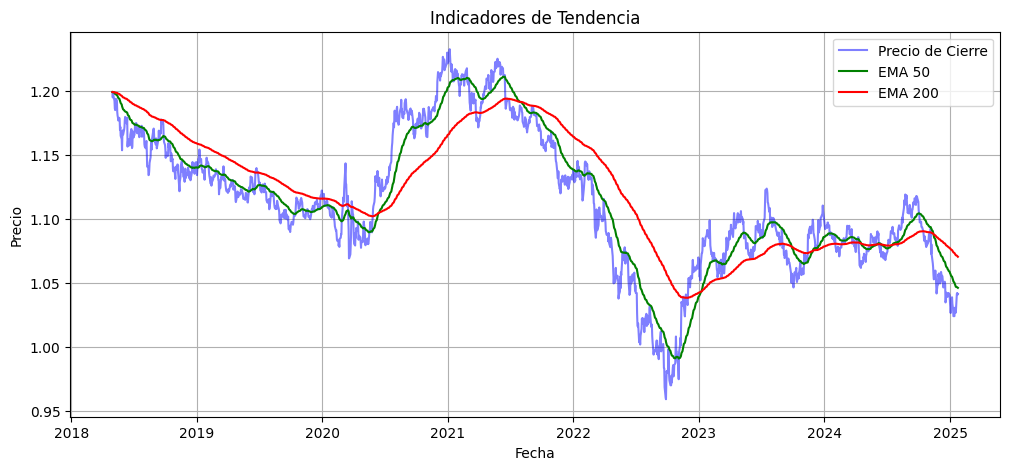

In [ ]:
def plot_sma_ema(df, short_window=50, long_window=200):
    """Calcula y grafica la SMA y EMA."""
    df[f'EMA_{short_window}'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df[f'EMA_{long_window}'] = df['Close'].ewm(span=long_window, adjust=False).mean()

    plt.figure(figsize=(12, 5))
    plt.plot(df['Time'], df['Close'], label='Precio de Cierre', color='blue', alpha=0.5)
    plt.plot(df['Time'], df[f'EMA_{short_window}'], label=f'EMA {short_window}', color='green')
    plt.plot(df['Time'], df[f'EMA_{long_window}'], label=f'EMA {long_window}', color='red')
    plt.xlabel("Fecha")
    plt.ylabel("Precio")
    plt.title(f"Indicadores de Tendencia")
    plt.legend()
    plt.grid()
    plt.show()

plot_sma_ema(df)


### Índice de Fuerza Relativa (RSI)

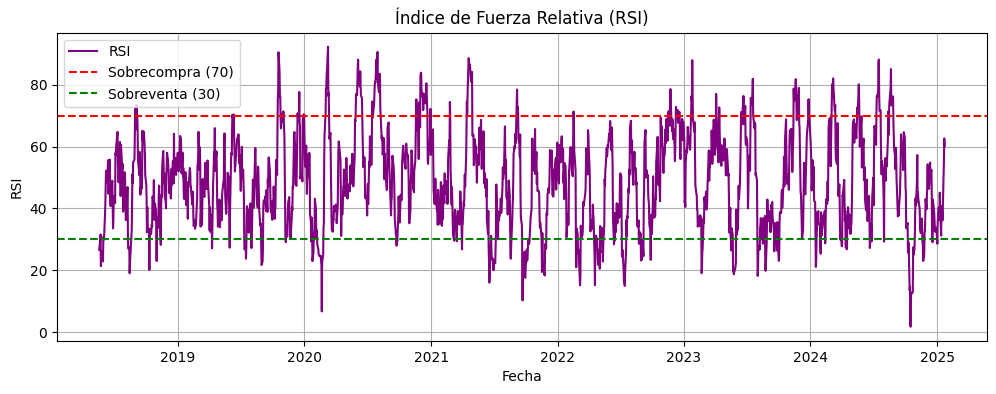

In [ ]:
def plot_rsi(df, window=14):
    """Calcula y grafica el RSI."""
    delta = df['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    plt.figure(figsize=(12, 4))
    plt.plot(df['Time'], df['RSI'], label='RSI', color='purple')
    plt.axhline(70, linestyle='--', color='red', label="Sobrecompra (70)")
    plt.axhline(30, linestyle='--', color='green', label="Sobreventa (30)")
    plt.xlabel("Fecha")
    plt.ylabel("RSI")
    plt.title(f"Índice de Fuerza Relativa (RSI)")
    plt.legend()
    plt.grid()
    plt.show()

plot_rsi(df)


### MACD

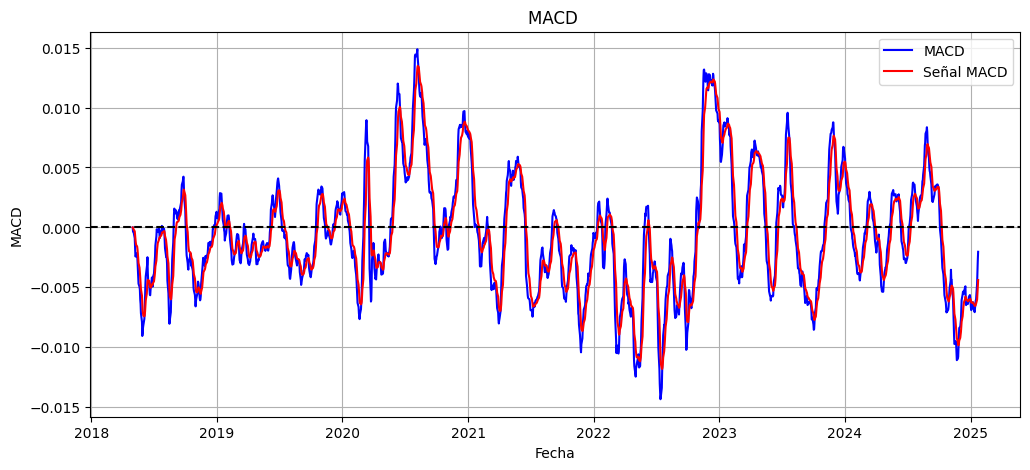

In [ ]:
def plot_macd(df, short_span=12, long_span=26, signal_span=9):
    """Calcula y grafica el MACD."""
    df['MACD'] = df['Close'].ewm(span=short_span, adjust=False).mean() - df['Close'].ewm(span=long_span, adjust=False).mean()
    df['Signal'] = df['MACD'].ewm(span=signal_span, adjust=False).mean()

    plt.figure(figsize=(12, 5))
    plt.plot(df['Time'], df['MACD'], label='MACD', color='blue')
    plt.plot(df['Time'], df['Signal'], label='Señal MACD', color='red')
    plt.axhline(0, linestyle='--', color='black')
    plt.xlabel("Fecha")
    plt.ylabel("MACD")
    plt.title(f"MACD ")
    plt.legend()
    plt.grid()
    plt.show()

plot_macd(df)


### Bollinger bands

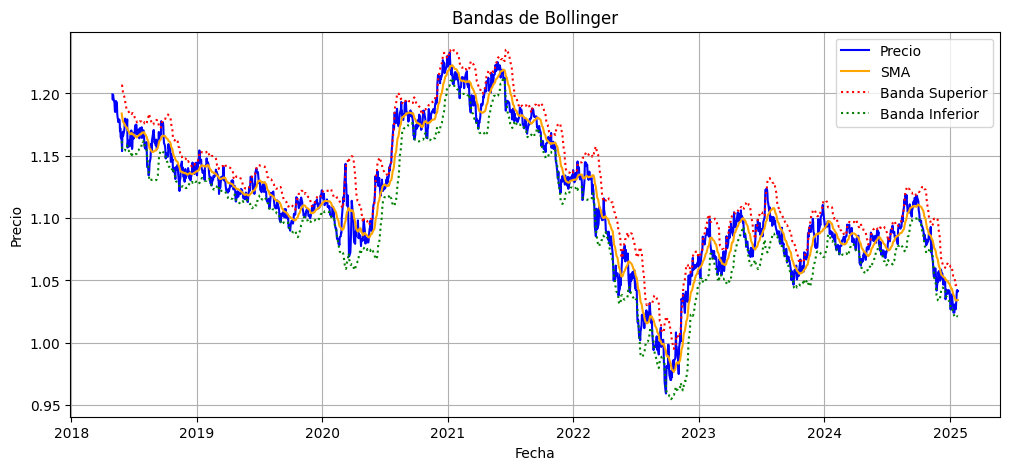

In [ ]:
def plot_bollinger_bands(df, window=20):
    """Calcula y grafica las Bandas de Bollinger."""
    df['SMA'] = df['Close'].rolling(window=window).mean()
    df['Upper'] = df['SMA'] + 2 * df['Close'].rolling(window=window).std()
    df['Lower'] = df['SMA'] - 2 * df['Close'].rolling(window=window).std()

    plt.figure(figsize=(12, 5))
    plt.plot(df['Time'], df['Close'], label='Precio', color='blue')
    plt.plot(df['Time'], df['SMA'], label='SMA', color='orange')
    plt.plot(df['Time'], df['Upper'], label='Banda Superior', color='red', linestyle='dotted')
    plt.plot(df['Time'], df['Lower'], label='Banda Inferior', color='green', linestyle='dotted')
    plt.xlabel("Fecha")
    plt.ylabel("Precio")
    plt.title(f"Bandas de Bollinger")
    plt.legend()
    plt.grid()
    plt.show()

plot_bollinger_bands(df)


### Soportes y resistencias (máximos y mínimos históricos)

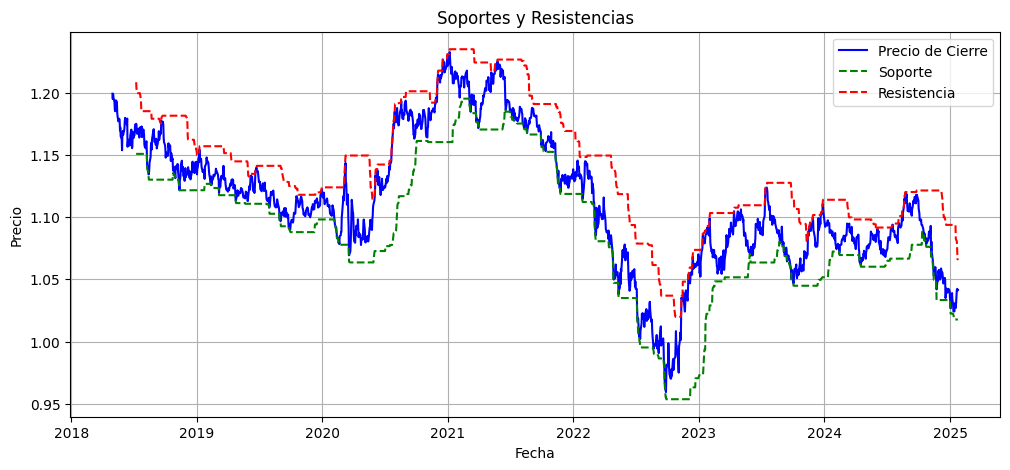

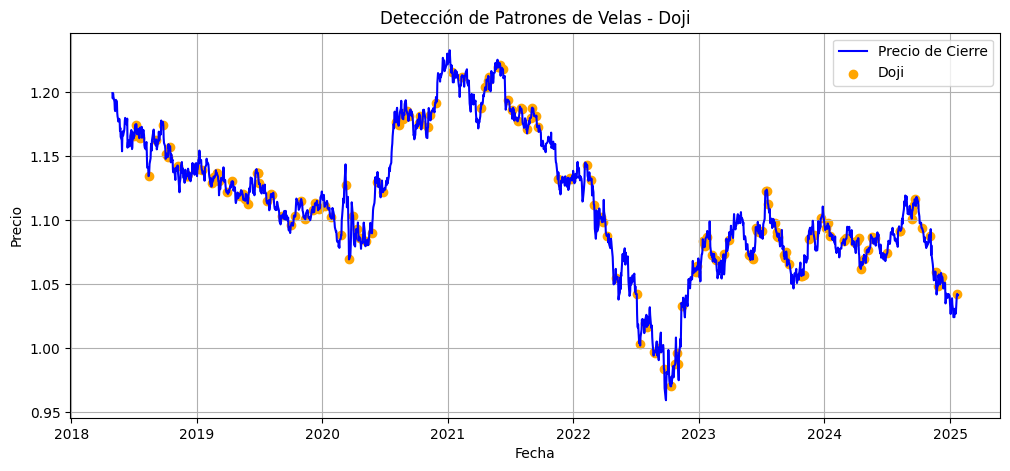

In [ ]:
df['Soporte'] = df['Low'].rolling(window=50).min()
df['Resistencia'] = df['High'].rolling(window=50).max()

plt.figure(figsize=(12, 5))
plt.plot(df['Time'], df['Close'], label='Precio de Cierre', color='blue')
plt.plot(df['Time'], df['Soporte'], label='Soporte', color='green', linestyle='dashed')
plt.plot(df['Time'], df['Resistencia'], label='Resistencia', color='red', linestyle='dashed')
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.title("Soportes y Resistencias")
plt.legend()
plt.grid()
plt.show()

df['Cuerpo'] = abs(df['Open'] - df['Close'])
df['Sombra'] = df['High'] - df['Low']
df['Doji'] = (df['Cuerpo'] / df['Sombra']) < 0.1

plt.figure(figsize=(12, 5))
plt.plot(df['Time'], df['Close'], label='Precio de Cierre', color='blue')
plt.scatter(df.loc[df['Doji'], 'Time'], df.loc[df['Doji'], 'Close'], color='orange', label='Doji', marker='o')
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.title("Detección de Patrones de Velas - Doji")
plt.legend()
plt.grid()
plt.show()

### Retrocesos de Fibonacci

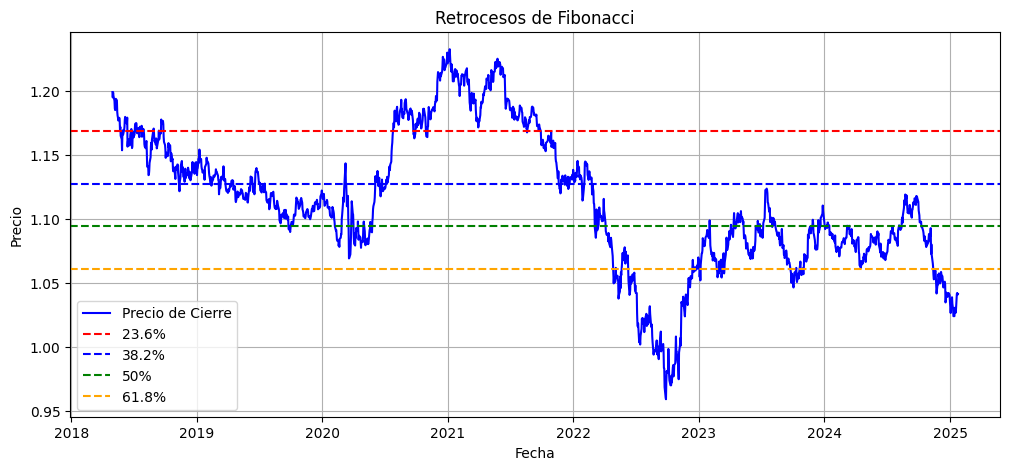

In [ ]:
precio_max = df['High'].max()
precio_min = df['Low'].min()

nivel_23_6 = precio_max - (precio_max - precio_min) * 0.236
nivel_38_2 = precio_max - (precio_max - precio_min) * 0.382
nivel_50 = precio_max - (precio_max - precio_min) * 0.5
nivel_61_8 = precio_max - (precio_max - precio_min) * 0.618

plt.figure(figsize=(12, 5))
plt.plot(df['Time'], df['Close'], label='Precio de Cierre', color='blue')
plt.axhline(y=nivel_23_6, color='red', linestyle='dashed', label='23.6%')
plt.axhline(y=nivel_38_2, color='blue', linestyle='dashed', label='38.2%')
plt.axhline(y=nivel_50, color='green', linestyle='dashed', label='50%')
plt.axhline(y=nivel_61_8, color='orange', linestyle='dashed', label='61.8%')

plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.title("Retrocesos de Fibonacci")
plt.legend()
plt.grid()
plt.show()


### Indicador de Fuerza de Tendencia

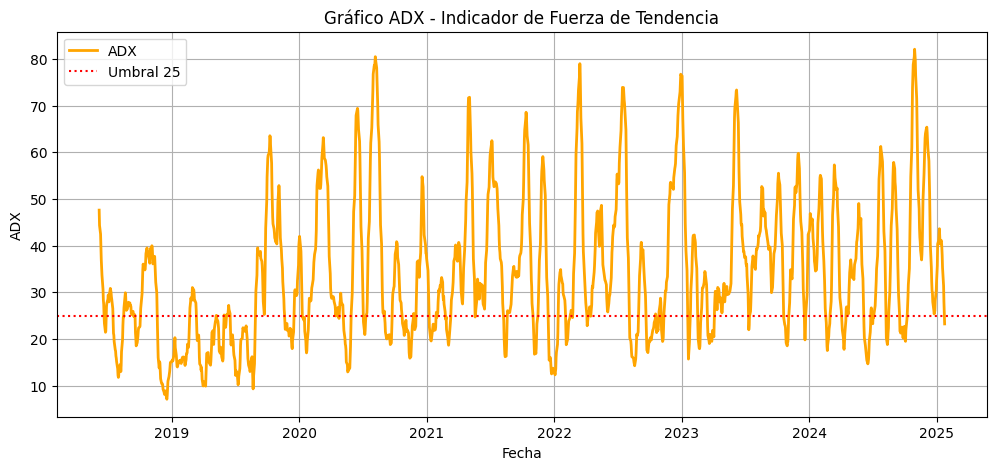

In [ ]:
def calcular_adx(df, n=14):
    df['TR'] = np.maximum(df['High'] - df['Low'],
                          np.maximum(abs(df['High'] - df['Close'].shift()),
                                     abs(df['Low'] - df['Close'].shift())))
    df['+DM'] = df['High'].diff()
    df['-DM'] = -df['Low'].diff()
    df['+DM'] = np.where(df['+DM'] > df['-DM'], df['+DM'], 0)
    df['-DM'] = np.where(df['-DM'] > df['+DM'], df['-DM'], 0)
    df['TR'] = df['TR'].rolling(window=n).sum()
    df['+DM'] = df['+DM'].rolling(window=n).sum()
    df['-DM'] = df['-DM'].rolling(window=n).sum()
    df['+DI'] = 100 * (df['+DM'] / df['TR'])
    df['-DI'] = 100 * (df['-DM'] / df['TR'])
    df['ADX'] = 100 * (abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])).rolling(window=n).mean()
    return df

df = calcular_adx(df)

plt.figure(figsize=(12, 5))
plt.plot(df['Time'], df['ADX'], label='ADX', color='orange', linewidth=2)
plt.axhline(y=25, color='red', linestyle='dotted', label='Umbral 25')
plt.xlabel("Fecha")
plt.ylabel("ADX")
plt.title("Gráfico ADX - Indicador de Fuerza de Tendencia")
plt.legend()
plt.grid()
plt.show()


# Preparación del dataset

In [ ]:
df = df_15min.copy()

In [ ]:
df.drop(columns=['Unnamed: 0', 'Spread', 'Real_volume', 'timeframe', 'symbol'], inplace=True)
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time')

In [ ]:
df.head(2)

,Time,Open,High,Low,Close,Volume
0,2020-11-11 09:30:00,1.18212,1.18243,1.18138,1.18145,890
1,2020-11-11 09:45:00,1.18145,1.18150,1.18070,1.18082,1134


# Modelado y prediciones

In [ ]:
seed_value = 42

## BackTesting

 Estrategía genérica que se utilizará a lo largo del código para evaluar e intentar optimizar el comportamiento de cada una de las estrategías definidas

In [ ]:
class GenericStrategy(Strategy):
    def init(self):
        pass

    def next(self):
        signal = self.data.Signal[-1]
        if signal == 1:
            self.position.close()
            self.buy()
        elif signal == -1:
            self.position.close()
            self.sell()


## **Estrategia 1**: Etiquetado en bases a reglas e indicadores

### SMA y EMA

In [ ]:
sma_df = df.copy()

In [ ]:
sma_df['Signal'] = 0

sma_df['SMA_50'] = sma_df['Close'].rolling(window=50).mean()  # Media móvil simple de 50 periodos
sma_df['SMA_20'] = sma_df['Close'].rolling(window=20).mean()  # Media móvil simple de 20 periodos
sma_df.dropna(inplace=True)

bullish_crossover = (sma_df['SMA_20'].shift(1) <= sma_df['SMA_50'].shift(1)) & (sma_df['SMA_20'] > sma_df['SMA_50'])
bearish_crossover = (sma_df['SMA_20'].shift(1) >= sma_df['SMA_50'].shift(1)) & (sma_df['SMA_20'] < sma_df['SMA_50'])

sma_df.loc[bullish_crossover, 'Signal'] = 1   # Compra
sma_df.loc[bearish_crossover, 'Signal'] = -1  # Venta

sma_df.head()

,Time,Open,High,Low,Close,Volume,Signal,SMA_50,SMA_20
49,2020-11-11 21:15:00,1.32166,1.32191,1.32113,1.32117,612,0,1.323890,1.320751
50,2020-11-11 21:30:00,1.32117,1.32160,1.32097,1.32130,668,0,1.323748,1.320734
51,2020-11-11 21:45:00,1.32130,1.32142,1.32072,1.32126,892,0,1.323612,1.320748
52,2020-11-11 22:00:00,1.32122,1.32132,1.32077,1.32081,525,0,1.323476,1.320770
53,2020-11-11 22:15:00,1.32081,1.32091,1.32062,1.32069,456,0,1.323337,1.320735


In [ ]:
sma_df['Action'] = sma_df['Signal'].map({1: 'Comprar', 0: 'Esperar', -1: 'Vender'})
sma_df.Action.value_counts()


,count
Action,
Esperar,102155
Comprar,1202
Vender,1201


In [ ]:
sma_df['Time'] = pd.to_datetime(sma_df['Time'])
sma_df.set_index('Time', inplace=True)
sma_df.index = pd.to_datetime(sma_df.index)

bt = Backtest(sma_df, GenericStrategy, cash=5000, commission=.000)
stats = bt.run()
print(stats)

Backtest.run:   0%|          | 0/104557 [00:00<?, ?it/s]

Start                     2020-11-11 21:15:00
End                       2025-01-24 23:30:00
Duration                   1535 days 02:15:00
Exposure Time [%]                     99.8575
Equity Final [$]                   4892.49414
Equity Peak [$]                    5618.84728
Return [%]                           -2.15012
Buy & Hold Return [%]                -5.50346
Return (Ann.) [%]                    -0.50079
Volatility (Ann.) [%]                 8.28493
CAGR [%]                             -0.35618
Sharpe Ratio                         -0.06045
Sortino Ratio                        -0.08372
Calmar Ratio                         -0.02792
Alpha [%]                            -2.32715
Beta                                 -0.03217
Max. Drawdown [%]                   -17.93613
Avg. Drawdown [%]                    -0.43187
Max. Drawdown Duration      851 days 19:45:00
Avg. Drawdown Duration        9 days 14:01:00
# Trades                                 2402
Win Rate [%]                      

In [ ]:
ema_df = df.copy()

In [ ]:
ema_df['EMA_50'] = ema_df['Close'].ewm(span=50, adjust=False).mean()  # EMA 50
ema_df['EMA_200'] = ema_df['Close'].ewm(span=200, adjust=False).mean()  # EMA 200

ema_df.dropna(inplace=True)

In [ ]:
ema_df['Signal'] = 0
bullish_crossover = (ema_df['EMA_200'].shift(1) <= ema_df['EMA_50'].shift(1)) & (ema_df['EMA_200'] > ema_df['EMA_50'])
bearish_crossover = (ema_df['EMA_200'].shift(1) >= ema_df['EMA_50'].shift(1)) & (ema_df['EMA_200'] < ema_df['EMA_50'])

ema_df.loc[bullish_crossover, 'Signal'] = 1
ema_df.loc[bearish_crossover, 'Signal'] = -1

In [ ]:
ema_df['Action'] = ema_df['Signal'].map({1: 'Comprar', 0: 'Esperar', -1: 'Vender'})
ema_df.Action.value_counts()

,count
Action,
Esperar,103933
Comprar,337
Vender,337


In [ ]:
ema_df['Time'] = pd.to_datetime(ema_df['Time'])
ema_df.set_index('Time', inplace=True)
ema_df.index = pd.to_datetime(ema_df.index)

bt = Backtest(ema_df, GenericStrategy, cash=5000, commission=.000)
stats = bt.run()
print(stats)

Backtest.run:   0%|          | 0/104606 [00:00<?, ?it/s]

Start                     2020-11-11 09:00:00
End                       2025-01-24 23:30:00
Duration                   1535 days 14:30:00
Exposure Time [%]                    99.60328
Equity Final [$]                   6145.29676
Equity Peak [$]                    6581.06122
Return [%]                           22.90594
Buy & Hold Return [%]                 -6.0206
Return (Ann.) [%]                     4.98183
Volatility (Ann.) [%]                 9.20965
CAGR [%]                              3.44258
Sharpe Ratio                          0.54094
Sortino Ratio                         0.80283
Calmar Ratio                          0.36849
Alpha [%]                            23.29566
Beta                                  0.06473
Max. Drawdown [%]                   -13.51963
Avg. Drawdown [%]                    -0.27926
Max. Drawdown Duration      575 days 00:15:00
Avg. Drawdown Duration        3 days 22:16:00
# Trades                                  673
Win Rate [%]                      

### MACD y RSI

In [ ]:
tmp_df = df.copy()
tmp_df.head(2)

,Time,Open,High,Low,Close,Volume
0,2020-11-11 09:00:00,1.32626,1.32882,1.32625,1.32844,1065
1,2020-11-11 09:15:00,1.32839,1.32850,1.32708,1.32803,823


In [ ]:
tmp_df['MACD'] = tmp_df['Close'].ewm(span=12, adjust=False).mean() - tmp_df['Close'].ewm(span=26, adjust=False).mean()
tmp_df['RSI'] = 100 - (100 / (1 + (tmp_df['Close'].diff(1).clip(lower=0).rolling(14).mean() / tmp_df['Close'].diff(1).clip(upper=0).abs().rolling(14).mean())))

tmp_df.dropna(inplace=True)
tmp_df.head(2)

,Time,Open,High,Low,Close,Volume,MACD,RSI
14,2020-11-11 12:30:00,1.32530,1.32620,1.32513,1.32584,1341,-0.000636,39.482201
15,2020-11-11 12:45:00,1.32583,1.32606,1.32514,1.32585,1384,-0.000674,40.886288


In [ ]:
tmp_df['Signal'] = 0
buy_condition = (tmp_df['MACD'] > 0) & (tmp_df['RSI'] < 30)
sell_condition = (tmp_df['MACD'] < 0) & (tmp_df['RSI'] > 70)

tmp_df.loc[buy_condition, 'Signal'] = 1
tmp_df.loc[sell_condition, 'Signal'] = -1


In [ ]:
tmp_df['Action'] = tmp_df['Signal'].map({1: 'Comprar', 0: 'Esperar', -1: 'Vender'})
tmp_df.Action.value_counts()

,count
Action,
Esperar,103005
Vender,847
Comprar,741


In [ ]:
tmp_df['Time'] = pd.to_datetime(tmp_df['Time'])
tmp_df.set_index('Time', inplace=True)
tmp_df.index = pd.to_datetime(tmp_df.index)

bt = Backtest(tmp_df, GenericStrategy, cash=5000, commission=.000)
stats = bt.run()
print(stats)

Backtest.run:   0%|          | 0/104592 [00:00<?, ?it/s]

Start                     2020-11-11 12:30:00
End                       2025-01-24 23:30:00
Duration                   1535 days 11:00:00
Exposure Time [%]                    99.87475
Equity Final [$]                   4690.37484
Equity Peak [$]                    5607.98447
Return [%]                            -6.1925
Buy & Hold Return [%]                 -5.8363
Return (Ann.) [%]                    -1.45934
Volatility (Ann.) [%]                 8.60419
CAGR [%]                             -1.04366
Sharpe Ratio                         -0.16961
Sortino Ratio                         -0.2375
Calmar Ratio                         -0.06167
Alpha [%]                             -6.8798
Beta                                 -0.11776
Max. Drawdown [%]                   -23.66476
Avg. Drawdown [%]                     -0.6607
Max. Drawdown Duration      812 days 23:30:00
Avg. Drawdown Duration       12 days 18:48:00
# Trades                                 1587
Win Rate [%]                      

### Estrategía hibrida

In [ ]:
hibrid_df = df.copy()

In [ ]:
hibrid_df['EMA_50'] = hibrid_df['Close'].ewm(span=50, adjust=False).mean()
hibrid_df['EMA_200'] = hibrid_df['Close'].ewm(span=200, adjust=False).mean()
hibrid_df['RSI'] = 100 - (100 / (1 + (hibrid_df['Close'].diff(1).clip(lower=0).rolling(14).mean() / hibrid_df['Close'].diff(1).clip(upper=0).abs().rolling(14).mean())))
hibrid_df['MACD'] = hibrid_df['Close'].ewm(span=12, adjust=False).mean() - hibrid_df['Close'].ewm(span=26, adjust=False).mean()
hibrid_df['MACD_Signal'] = hibrid_df['MACD'].ewm(span=9, adjust=False).mean()

hibrid_df.dropna(inplace=True)

In [ ]:
# Generar señales
hibrid_df['Signal'] = 0

# Señal de compra
bullish_crossover_50_200 = (hibrid_df['EMA_50'] > hibrid_df['EMA_200'])  # Tendencia alcista
rsi_buy = (hibrid_df['RSI'] < 70) & (hibrid_df['RSI'] > 30)  # RSI en rango saludable
macd_buy = (hibrid_df['MACD'] > hibrid_df['MACD_Signal'])  # MACD confirmando tendencia alcista

hibrid_df.loc[bullish_crossover_50_200 & rsi_buy & macd_buy, 'Signal'] = 1  # Comprar

# Señal de venta
bearish_crossover_50_200 = (hibrid_df['EMA_50'] < hibrid_df['EMA_200'])  # Tendencia bajista
rsi_sell = (hibrid_df['RSI'] > 30) & (hibrid_df['RSI'] < 70)  # RSI en rango saludable
macd_sell = (hibrid_df['MACD'] < hibrid_df['MACD_Signal'])  # MACD confirmando tendencia bajista

hibrid_df.loc[bearish_crossover_50_200 & rsi_sell & macd_sell, 'Signal'] = -1  # Vender


In [ ]:
hibrid_df['Action'] = hibrid_df['Signal'].map({1: 'Comprar', 0: 'Esperar', -1: 'Vender'})
hibrid_df.Action.value_counts()

,count
Action,
Esperar,73165
Vender,15741
Comprar,15687


In [ ]:
hibrid_df['Time'] = pd.to_datetime(hibrid_df['Time'])
hibrid_df.set_index('Time', inplace=True)
hibrid_df.index = pd.to_datetime(hibrid_df.index)

bt = Backtest(hibrid_df, GenericStrategy, cash=5000, commission=.000)
stats = bt.run()
print(stats)

Backtest.run:   0%|          | 0/104592 [00:00<?, ?it/s]

Start                     2020-11-11 12:30:00
End                       2025-01-24 23:30:00
Duration                   1535 days 11:00:00
Exposure Time [%]                    99.97323
Equity Final [$]                    4040.1251
Equity Peak [$]                     5057.6257
Return [%]                           -19.1975
Buy & Hold Return [%]                 -5.8363
Return (Ann.) [%]                    -4.86102
Volatility (Ann.) [%]                 8.43149
CAGR [%]                             -3.43794
Sharpe Ratio                         -0.57653
Sortino Ratio                         -0.7802
Calmar Ratio                         -0.18757
Alpha [%]                           -19.62421
Beta                                 -0.07311
Max. Drawdown [%]                   -25.91563
Avg. Drawdown [%]                    -1.89655
Max. Drawdown Duration     1528 days 06:15:00
Avg. Drawdown Duration      102 days 08:29:00
# Trades                                31426
Win Rate [%]                      

#### Optimización utilizando grid search

In [ ]:
sma_df = df_15min.copy()
sma_df.drop(columns=['Unnamed: 0', 'Spread', 'Real_volume', 'timeframe', 'symbol'], inplace=True)
sma_df['Time'] = pd.to_datetime(sma_df['Time'])
sma_df = df.sort_values('Time')

if not isinstance(sma_df.index, pd.DatetimeIndex):
    sma_df.index = pd.to_datetime(sma_df.index)

fast_sma_values = range(5, 50, 5)
slow_sma_values = range(50, 201, 10)

best_sharpe_ratio = -np.inf
best_params = {}

for fast_sma, slow_sma in product(fast_sma_values, slow_sma_values):
    opt_df = sma_df.copy()
    if fast_sma >= slow_sma:
        continue

    opt_df['Fast_SMA'] = opt_df['Close'].rolling(window=fast_sma).mean()
    opt_df['Slow_SMA'] = opt_df['Close'].rolling(window=slow_sma).mean()
    opt_df.dropna(inplace=True)

    opt_df['Signal'] = 0
    bullish_crossover = (opt_df['Fast_SMA'].shift(1) <= opt_df['Slow_SMA'].shift(1)) & (opt_df['Fast_SMA'] > opt_df['Slow_SMA'])
    bearish_crossover = (opt_df['Fast_SMA'].shift(1) >= opt_df['Slow_SMA'].shift(1)) & (opt_df['Fast_SMA'] < opt_df['Slow_SMA'])
    opt_df.loc[bullish_crossover, 'Signal'] = 1
    opt_df.loc[bearish_crossover, 'Signal'] = -1

    print(opt_df.Signal.value_counts())

    opt_df['Signal'] = opt_df['Signal'].astype(int)

    data = opt_df[['Open', 'High', 'Low', 'Close', 'Volume', 'Signal']]
    bt = Backtest(data, GenericStrategy, cash=10000, commission=0.001)
    stats = bt.run()
    sharpe_ratio = stats['Sharpe Ratio']

    if sharpe_ratio > best_sharpe_ratio:
        best_sharpe_ratio = sharpe_ratio
        best_params = {'Fast_SMA': fast_sma, 'Slow_SMA': slow_sma}

    print(f"Best parameters: {best_params}")
    print(f"Best Sharpe ratio: {best_sharpe_ratio}")


print(f" Final best parameters: {best_params}")
print(f" Final best Sharpe ratio: {best_sharpe_ratio}")


## **Estrategía 2**: Autoencoder + *clustering*

In [ ]:
autoencoder_df = df.copy()

In [ ]:
autoencoder_df['SMA_50'] = autoencoder_df['Close'].rolling(window=50).mean()  # Media móvil simple de 50 periodos
autoencoder_df['SMA_20'] = autoencoder_df['Close'].rolling(window=20).mean()  # Media móvil simple de 20 periodos
autoencoder_df['EMA_50'] = autoencoder_df['Close'].ewm(span=50, adjust=False).mean()  # Media móvil exponencial de 50 periodos
autoencoder_df['MACD'] = autoencoder_df['Close'].ewm(span=12, adjust=False).mean() - autoencoder_df['Close'].ewm(span=26, adjust=False).mean()  # MACD
autoencoder_df['RSI'] = 100 - (100 / (1 + (autoencoder_df['Close'].diff(1).clip(lower=0).rolling(14).mean() / autoencoder_df['Close'].diff(1).clip(upper=0).abs().rolling(14).mean())))  # RSI
autoencoder_df['ADX'] = (autoencoder_df['High'] - autoencoder_df['Low']).rolling(window=14).mean()  # ADX simplificado
autoencoder_df['Bollinger_High'] = autoencoder_df['Close'].rolling(window=20).mean() + 2 * autoencoder_df['Close'].rolling(window=20).std()
autoencoder_df['Bollinger_Low'] = autoencoder_df['Close'].rolling(window=20).mean() - 2 * autoencoder_df['Close'].rolling(window=20).std()
autoencoder_df['Volatility'] = autoencoder_df['High'] - df['Low']

autoencoder_df.dropna(inplace=True)

In [ ]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(autoencoder_df[['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_50', 'EMA_50', 'MACD', 'RSI', 'ADX', 'Bollinger_High', 'Bollinger_Low', 'Volatility']])

In [ ]:
input_layer = Input(shape=(df_scaled.shape[1],))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(df_scaled.shape[1], activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 13)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 13)                  │             845 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,933 (23.18 KB)

 Trainable params: 5,933 (23.18 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder.fit(df_scaled, df_scaled, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)

Epoch 1/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.5027e-06 - val_loss: 7.0270e-06
Epoch 2/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.5072e-06 - val_loss: 7.1617e-06
Epoch 3/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.4463e-06 - val_loss: 7.1472e-06
Epoch 4/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.4562e-06 - val_loss: 6.9442e-06
Epoch 5/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 7.6742e-06 - val_loss: 6.9667e-06
Epoch 6/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.3745e-06 - val_loss: 6.8885e-06
Epoch 7/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.1513e-06 - val_loss: 8.3602e-06
Epoch 8/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.0241e-06 - val_loss: 1.1184e-05
Epoch 9/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.4876e-06 - val_loss: 6.2686e-06
Epoch 10/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.8632e-06 - val_loss: 6.9864e-06
Epoch 11/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss

In [ ]:
# 3. Extraer las características comprimidas del autoencoder (Codificación)
encoder = Model(input_layer, encoded)
encoded_data = encoder.predict(df_scaled)

3268/3268 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


In [ ]:
# 4. Aplicar PCA para reducción adicional de la dimensionalidad
pca = PCA(n_components=0.95)
encoded_data_pca = pca.fit_transform(encoded_data)

### KMEANS

In [ ]:
# 5. Clustering con K-Means para identificar patrones
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(encoded_data_pca)
    wcss.append(kmeans.inertia_)


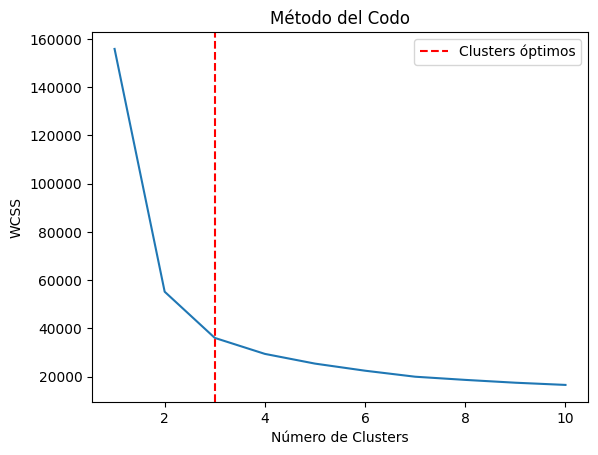

In [ ]:
# Mostrar el gráfico del codo
plt.plot(range(1, 11), wcss)
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')

optimal_clusters = 3
plt.axvline(x=optimal_clusters, color='red', linestyle='--', label=f'Clusters óptimos')

plt.legend()
plt.show()

In [ ]:
# Realizar el clustering con 3 clusters fijos
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
autoencoder_df['Cluster'] = kmeans.fit_predict(encoded_data_pca)

In [ ]:
# 7. Caracterizar los clusters usando los datos originales
cluster_stats = autoencoder_df.groupby('Cluster').agg({
    'Close': 'mean',
    'SMA_50': 'mean',
    'EMA_50': 'mean',
    'MACD': 'mean',
    'RSI': 'mean',
    'ADX': 'mean',
    'Volatility': 'mean',
    'Volume': 'mean'
}).sort_values(by='Close')

print("\nEstadísticas de cada cluster:")
print(cluster_stats.to_string())


Estadísticas de cada cluster:
            Close    SMA_50    EMA_50      MACD        RSI       ADX  Volatility       Volume
Cluster                                                                                      
0        1.194825  1.194981  1.194972 -0.000046  49.365332  0.001280    0.001298  1059.238694
2        1.270427  1.270436  1.270437 -0.000003  50.299475  0.000768    0.000762   755.263867
1        1.367847  1.367780  1.367785  0.000020  50.596609  0.000860    0.000855   687.265543


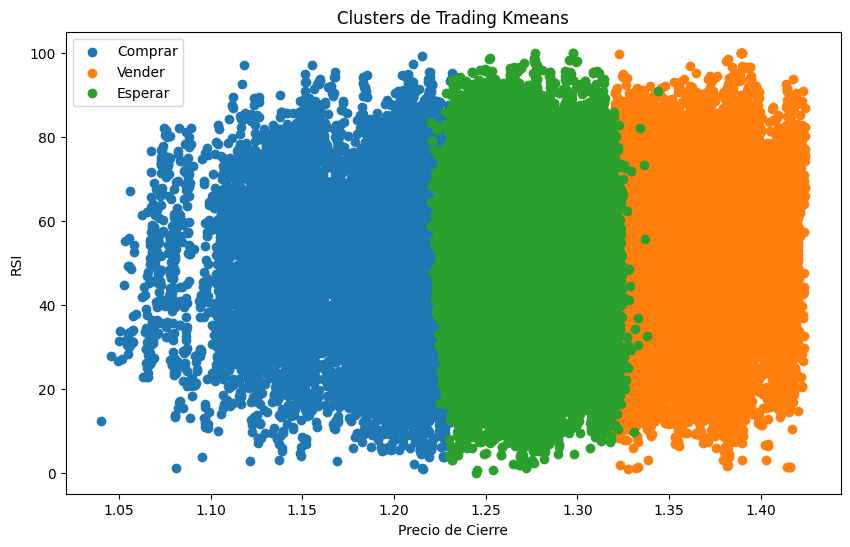

In [ ]:
# Etiquetado automático de clusters
labels = {}

# Cluster con menor cierre y tendencia positiva -> Comprar
buy_cluster = cluster_stats['Close'].idxmin()

# Cluster con mayor cierre y tendencia negativa -> Vender
sell_cluster = cluster_stats['Close'].idxmax()

# El cluster restante -> Esperar
wait_cluster = list(set(cluster_stats.index) - {buy_cluster, sell_cluster})[0]

labels[buy_cluster] = 'Comprar'
labels[sell_cluster] = 'Vender'
labels[wait_cluster] = 'Esperar'

autoencoder_df['Kmeans_Action'] = autoencoder_df['Cluster'].map(labels)

plt.figure(figsize=(10, 6))
for label in ['Comprar', 'Vender', 'Esperar']:
    subset = autoencoder_df[autoencoder_df['Kmeans_Action'] == label]
    plt.scatter(subset['Close'], subset['RSI'], label=label)

plt.title('Clusters de Trading Kmeans')
plt.xlabel('Precio de Cierre')
plt.ylabel('RSI')
plt.legend()
plt.show()


In [ ]:
autoencoder_df.Kmeans_Action.value_counts()

,count
Kmeans_Action,
Esperar,47270
Vender,33584
Comprar,23704


In [ ]:
action_map = {'Vender': -1, 'Esperar': 0, 'Comprar': 1}
autoencoder_df['Signal'] = autoencoder_df['Kmeans_Action'].map(action_map)

In [ ]:
# Backtest
bt = Backtest(autoencoder_df, GenericStrategy, cash=5000, commission=.000)
stats = bt.run()
print(stats)

Backtest.run:   0%|          | 0/104557 [00:00<?, ?it/s]

Start                                    49.0
End                                  104606.0
Duration                             104557.0
Exposure Time [%]                    99.95218
Equity Final [$]                   5856.70526
Equity Peak [$]                    6006.81726
Return [%]                           17.13411
Buy & Hold Return [%]                -5.50346
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Alpha [%]                            19.70827
Beta                                  0.46774
Max. Drawdown [%]                   -17.83111
Avg. Drawdown [%]                    -0.43611
Max. Drawdown Duration                32976.0
Avg. Drawdown Duration              508.99512
# Trades                              57287.0
Win Rate [%]                         49.43705
Best Trade [%]                    

### GMM

In [ ]:
# Aplicar GMM para detectar los clusters
gmm = GaussianMixture(n_components=3)
gmm.fit(encoded_data)

clusters = gmm.predict(encoded_data)
autoencoder_df['Gmm_Cluster'] = clusters

In [ ]:
columns_of_interest = [
    'Open', 'High', 'Low', 'Close', 'Volume', 'SMA_50', 'SMA_20', 'EMA_50',
    'MACD', 'RSI', 'ADX', 'Bollinger_High', 'Bollinger_Low', 'Volatility', 'Gmm_Cluster'
]

cluster_means = autoencoder_df[columns_of_interest].groupby('Gmm_Cluster').mean()

for cluster in range(3):
    cluster_data = autoencoder_df[autoencoder_df['Gmm_Cluster'] == cluster]
    print(f"Cluster {cluster}:")
    print(cluster_data[['Close', 'RSI', 'MACD', 'ADX']].mean())
    print("-" * 30)

autoencoder_df['Gmm_Action'] = autoencoder_df['Gmm_Cluster'].map({
    0: 'Comprar',   # Cluster 0: Comportamiento alcista
    1: 'Vender',   # Cluster 1: Comportamiento bajista
    2: 'Esperar'   # Cluster 2: Comportamiento lateral
})

Cluster 0:
Close     1.169573
RSI      50.648766
MACD      0.000091
ADX       0.001737
dtype: float64
------------------------------
Cluster 1:
Close     1.288778
RSI      49.942223
MACD     -0.000057
ADX       0.001128
dtype: float64
------------------------------
Cluster 2:
Close     1.295728
RSI      50.283314
MACD      0.000017
ADX       0.000675
dtype: float64
------------------------------


In [ ]:
autoencoder_df.head()

,Time,Open,High,Low,Close,Volume,SMA_50,SMA_20,EMA_50,MACD,RSI,ADX,Bollinger_High,Bollinger_Low,Volatility,Cluster,Trading_Action,Signal,Gmm_Cluster,Gmm_Action
49,2020-11-11 21:15:00,1.32166,1.32191,1.32113,1.32117,612,1.323890,1.320751,1.323268,-0.000678,61.514683,0.000855,1.322016,1.319486,0.00078,0,Comprar,1,2,Esperar
50,2020-11-11 21:30:00,1.32117,1.32160,1.32097,1.32130,668,1.323748,1.320734,1.323191,-0.000613,60.971787,0.000812,1.321958,1.319510,0.00063,0,Comprar,1,2,Esperar
51,2020-11-11 21:45:00,1.32130,1.32142,1.32072,1.32126,892,1.323612,1.320748,1.323115,-0.000558,60.781250,0.000826,1.321990,1.319506,0.00070,0,Comprar,1,2,Esperar
52,2020-11-11 22:00:00,1.32122,1.32132,1.32077,1.32081,525,1.323476,1.320770,1.323025,-0.000545,50.993377,0.000792,1.321999,1.319540,0.00055,0,Comprar,1,2,Esperar
53,2020-11-11 22:15:00,1.32081,1.32091,1.32062,1.32069,456,1.323337,1.320735,1.322933,-0.000538,52.739726,0.000747,1.321931,1.319539,0.00029,0,Comprar,1,2,Esperar


In [ ]:
action_map = {'Vender': -1, 'Esperar': 0, 'Comprar': 1}
autoencoder_df['Signal'] = autoencoder_df['Gmm_Action'].map(action_map)

In [ ]:
autoencoder_df.Gmm_Action.value_counts()

,count
Gmm_Action,
Esperar,59085
Vender,38345
Comprar,7128


In [ ]:
# Backtest
bt = Backtest(autoencoder_df, GenericStrategy, cash=5000, commission=.000)
stats = bt.run()
print(stats)

Backtest.run:   0%|          | 0/93234 [00:00<?, ?it/s]

Start                                    49.0
End                                   93283.0
Duration                              93234.0
Exposure Time [%]                    99.80908
Equity Final [$]                   5325.73878
Equity Peak [$]                    5575.73778
Return [%]                            6.51478
Buy & Hold Return [%]                -3.45527
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Alpha [%]                              8.6779
Beta                                  0.62604
Max. Drawdown [%]                   -22.10623
Avg. Drawdown [%]                    -0.53441
Max. Drawdown Duration                60774.0
Avg. Drawdown Duration              861.85185
# Trades                              36616.0
Win Rate [%]                         49.56576
Best Trade [%]                    

## **Estrategía 3** : Predicción precio futuro + *etiquetado*

In [ ]:
def generate_signal_numeric(previous_predicted_price, predicted_price, threshold=0.01):
    """
    Genera señales basadas en el cambio porcentual entre la predicción anterior y la predicción actual.
    - 1: BUY (si el cambio es mayor al threshold)
    - -1: SELL (si el cambio es menor al -threshold)
    - 0: WAIT (si el cambio está dentro del rango de -threshold a threshold)
    """
    change = (predicted_price - previous_predicted_price) / previous_predicted_price
    if change > threshold:
        return 1   # BUY
    elif change < -threshold:
        return -1  # SELL
    else:
        return 0   # WAIT

In [ ]:
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i, 3])  # Índice 3 corresponde a 'Close'
    return np.array(X), np.array(y)

### RNN

In [ ]:
rnn_df = df.copy()

rnn_df['SMA_50'] = rnn_df['Close'].rolling(window=50).mean()  # Media móvil simple de 50 periodos
rnn_df['SMA_20'] = rnn_df['Close'].rolling(window=20).mean()  # Media móvil simple de 20 periodos
rnn_df['EMA_50'] = rnn_df['Close'].ewm(span=50, adjust=False).mean()  # Media móvil exponencial de 50 periodos
rnn_df['MACD'] = rnn_df['Close'].ewm(span=12, adjust=False).mean() - rnn_df['Close'].ewm(span=26, adjust=False).mean()  # MACD
rnn_df['RSI'] = 100 - (100 / (1 + (rnn_df['Close'].diff(1).clip(lower=0).rolling(14).mean() / rnn_df['Close'].diff(1).clip(upper=0).abs().rolling(14).mean())))  # RSI
rnn_df['ADX'] = (rnn_df['High'] - rnn_df['Low']).rolling(window=14).mean()  # ADX simplificado
rnn_df['Bollinger_High'] = rnn_df['Close'].rolling(window=20).mean() + 2 * rnn_df['Close'].rolling(window=20).std()
rnn_df['Bollinger_Low'] = rnn_df['Close'].rolling(window=20).mean() - 2 * rnn_df['Close'].rolling(window=20).std()
rnn_df['Volatility'] = rnn_df['High'] - df['Low']

rnn_df.dropna(inplace=True)

In [ ]:
# Definir las características y etiquetas (Close)
X = rnn_df[['Close', 'SMA_50', 'SMA_20', 'EMA_50', 'MACD', 'RSI', 'ADX', 'Bollinger_High', 'Bollinger_Low', 'Volatility']].values
y = rnn_df['Close'].shift(-1).dropna().values  # Predecimos el siguiente precio de cierre

In [ ]:
# Normalización de las características
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Normalizar las características

In [ ]:
sequence_length = 60  # Puedes cambiar este valor si lo necesitas
X_seq, y_seq = create_sequences(X_scaled, sequence_length)

In [ ]:
# Dividir en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

In [ ]:
# Construcción del modelo RNN (LSTM o SimpleRNN)
model = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(sequence_length, X_train.shape[2])),  # X_train.shape[2] es el número de características
    Dense(25, activation='relu'),
    Dense(1)  # Predicción de un solo valor (precio de cierre)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 50)                  │           3,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,351 (17.00 KB)

 Trainable params: 4,351 (17.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entrenar el modelo
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.0013 - val_loss: 1.2138e-05
Epoch 2/20
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 2.3548e-05 - val_loss: 2.1847e-05
Epoch 3/20
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 1.2574e-05 - val_loss: 5.3313e-06
Epoch 4/20
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 9.5641e-06 - val_loss: 5.6708e-06
Epoch 5/20
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 1.5039e-05 - val_loss: 6.2027e-07
Epoch 6/20
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - loss: 2.0909e-06 - val_loss: 4.3533e-06
Epoch 7/20
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 3.8749e-06 - val_loss: 8.9339e-07
Epoch 8/20
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 3.3530e-06 - val_loss: 3.0697e-06
Epoch 9/20
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - loss: 3.1506e-06 - val_loss: 1.7596e-06
Epoch 10/20
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 2.7178e-06 - val_loss: 1.1316e-07
Epoch 11/20
2613/2613 ━

In [ ]:
save_path = "rnn.keras"
model.save(save_path)
print(f"Modelo guardado en Google Drive en la ruta: {save_path}")

Modelo guardado en Google Drive en la ruta: rnn.keras


In [ ]:
model = load_model("rnn.keras")

In [ ]:
test_predictions = model.predict(X_test)

predictions = test_predictions

predictions_with_zeros = np.zeros((predictions.shape[0], X_test.shape[2]))

predictions_with_zeros[:, 0] = predictions.flatten()

predictions_descaled = scaler.inverse_transform(predictions_with_zeros)
predictions_descaled = predictions_descaled[:, 0]

test_start_idx = len(rnn_df) - len(X_test)

if len(predictions_descaled) == len(X_test):
    rnn_df['Predicted_Close'] = np.nan
    rnn_df.iloc[test_start_idx:, rnn_df.columns.get_loc('Predicted_Close')] = predictions_descaled
    rnn_df_no_nan = rnn_df.dropna(subset=['Predicted_Close'])

    rnn_df_no_nan['Signal'] = rnn_df_no_nan.apply(lambda row: generate_signal_numeric(row['Close'], row['Predicted_Close'], threshold=0.01), axis=1)

    print(rnn_df_no_nan[['Close', 'Predicted_Close', 'Signal']].head())


654/654 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
         Close  Predicted_Close  Signal
83707  1.26063         1.252411       0
83708  1.26065         1.252650       0
83709  1.26067         1.252719       0
83710  1.26064         1.252636       0
83711  1.26057         1.252566       0


In [ ]:
rnn_df_no_nan = rnn_df.dropna(subset=['Predicted_Close'])

In [ ]:
rnn_df_no_nan['Signal'] = rnn_df_no_nan.apply(lambda row: generate_signal_numeric(row['Close'], row['Predicted_Close'], threshold=0.01), axis=1)
print(rnn_df_no_nan[['Close', 'Predicted_Close', 'Signal']].head())

         Close  Predicted_Close  Signal
83707  1.26063         1.252411       0
83708  1.26065         1.252650       0
83709  1.26067         1.252719       0
83710  1.26064         1.252636       0
83711  1.26057         1.252566       0


In [ ]:
y_true = rnn_df_no_nan['Close']  # Valores reales
y_pred = rnn_df_no_nan['Predicted_Close']  # Predicciones

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 5.263452936050432e-05
Mean Absolute Error (MAE): 0.006919257614931884
R² Score: 0.9249342589469655


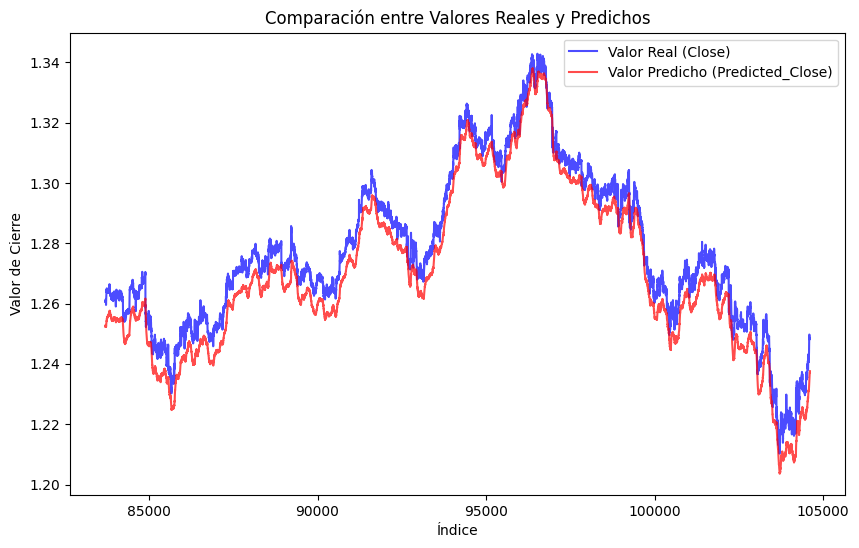

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='Valor Real (Close)', color='blue', alpha=0.7)
plt.plot(y_pred, label='Valor Predicho (Predicted_Close)', color='red', alpha=0.7)
plt.title('Comparación entre Valores Reales y Predichos')
plt.xlabel('Índice')
plt.ylabel('Valor de Cierre')
plt.legend()
plt.show()


In [ ]:
# Backtest
bt = Backtest(rnn_df_no_nan, GenericStrategy, cash=5000, commission=.000)
stats = bt.run()
print(stats)

Backtest.run:   0%|          | 0/20899 [00:00<?, ?it/s]

Start                                 83707.0
End                                  104606.0
Duration                              20899.0
Exposure Time [%]                    96.47847
Equity Final [$]                   5035.69253
Equity Peak [$]                    5193.67724
Return [%]                            0.71385
Buy & Hold Return [%]                -0.96539
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Alpha [%]                            -0.22234
Beta                                 -0.96975
Max. Drawdown [%]                    -8.53502
Avg. Drawdown [%]                     -0.4311
Max. Drawdown Duration                17949.0
Avg. Drawdown Duration              468.18605
# Trades                                231.0
Win Rate [%]                         39.82684
Best Trade [%]                    

### LSTM

In [ ]:
lstm_df = df.copy()

lstm_df['SMA_50'] = lstm_df['Close'].rolling(window=50).mean()  # Media móvil simple de 50 periodos
lstm_df['SMA_20'] = lstm_df['Close'].rolling(window=20).mean()  # Media móvil simple de 20 periodos
lstm_df['EMA_50'] = lstm_df['Close'].ewm(span=50, adjust=False).mean()  # Media móvil exponencial de 50 periodos
lstm_df['MACD'] = lstm_df['Close'].ewm(span=12, adjust=False).mean() - lstm_df['Close'].ewm(span=26, adjust=False).mean()  # MACD
lstm_df['RSI'] = 100 - (100 / (1 + (lstm_df['Close'].diff(1).clip(lower=0).rolling(14).mean() / lstm_df['Close'].diff(1).clip(upper=0).abs().rolling(14).mean())))  # RSI
lstm_df['ADX'] = (lstm_df['High'] - lstm_df['Low']).rolling(window=14).mean()  # ADX simplificado
lstm_df['Bollinger_High'] = lstm_df['Close'].rolling(window=20).mean() + 2 * lstm_df['Close'].rolling(window=20).std()
lstm_df['Bollinger_Low'] = lstm_df['Close'].rolling(window=20).mean() - 2 * lstm_df['Close'].rolling(window=20).std()
lstm_df['Volatility'] = lstm_df['High'] - df['Low']

lstm_df.dropna(inplace=True)

In [ ]:
# Definir las características y etiquetas (Close)
X = lstm_df[['Close', 'SMA_50', 'SMA_20', 'EMA_50', 'MACD', 'RSI', 'ADX', 'Bollinger_High', 'Bollinger_Low', 'Volatility']].values
y = lstm_df['Close'].shift(-1).dropna().values

In [ ]:
# Normalización de las características
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Normalizar las características

In [ ]:
sequence_length = 60  # Puedes cambiar este valor si lo necesitas
X_seq, y_seq = create_sequences(X_scaled, sequence_length)

In [ ]:
# Dividir en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

In [ ]:
# Construir el modelo LSTM
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=25))
model.add(Dense(units=1))

# Compilación del modelo
model.compile(optimizer='adam', loss='mse')

# Resumen del modelo
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          12,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,701 (131.64 KB)

 Trainable params: 33,701 (131.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entrenamiento del modelo
early_stopping = EarlyStopping(monitor='val_loss',patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), shuffle=False, callbacks=[early_stopping])


Epoch 1/50
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 172s 66ms/step - loss: 0.0025 - val_loss: 0.0072
Epoch 2/50
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 165s 63ms/step - loss: 0.0032 - val_loss: 0.0073
Epoch 3/50
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 191s 59ms/step - loss: 0.0033 - val_loss: 0.0073
Epoch 4/50
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 164s 63ms/step - loss: 0.0035 - val_loss: 0.0071
Epoch 5/50
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 192s 59ms/step - loss: 0.0037 - val_loss: 0.0065
Epoch 6/50
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 212s 63ms/step - loss: 0.0035 - val_loss: 0.0062
Epoch 7/50
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 202s 63ms/step - loss: 0.0035 - val_loss: 0.0056
Epoch 8/50
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 154s 59ms/step - loss: 0.0033 - val_loss: 0.0049
Epoch 9/50
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 153s 58ms/step - loss: 0.0032 - val_loss: 0.0045
Epoch 10/50
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 154s 59ms/step - loss: 0.0030 - val_loss: 0.0039
Epoch 11/50
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 202s 59ms/step - loss: 0.0028 - val_loss: 0.00

In [ ]:
save_path = "lstm.keras"
model.save(save_path)
print(f"Modelo guardado en Google Drive en la ruta: {save_path}")


Modelo guardado en Google Drive en la ruta: lstm.keras


In [ ]:
model = load_model("lstm.keras")

In [ ]:
loss = model.evaluate(X_test, y_test)
print(f"Pérdida en el conjunto de prueba: {loss}")

654/654 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - loss: 0.0026
Pérdida en el conjunto de prueba: 0.004364217631518841


In [ ]:
test_predictions = model.predict(X_test)

predictions = test_predictions

predictions_with_zeros = np.zeros((predictions.shape[0], X_test.shape[2]))

predictions_with_zeros[:, 0] = predictions.flatten()

predictions_descaled = scaler.inverse_transform(predictions_with_zeros)
predictions_descaled = predictions_descaled[:, 0]

test_start_idx = len(lstm_df) - len(X_test)

if len(predictions_descaled) == len(X_test):
    lstm_df['Predicted_Close'] = np.nan
    lstm_df.iloc[test_start_idx:, lstm_df.columns.get_loc('Predicted_Close')] = predictions_descaled
    lstm_df_no_nan = lstm_df.dropna(subset=['Predicted_Close'])

    lstm_df_no_nan['Signal'] = lstm_df_no_nan.apply(lambda row: generate_signal_numeric(row['Close'], row['Predicted_Close'], threshold=0.01), axis=1)

    print(lstm_df_no_nan[['Close', 'Predicted_Close', 'Signal']].head())


654/654 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step
         Close  Predicted_Close  Signal
83707  1.26063         1.243248      -1
83708  1.26065         1.243026      -1
83709  1.26067         1.242889      -1
83710  1.26064         1.242833      -1
83711  1.26057         1.242885      -1


In [ ]:
lstm_df_no_nan = lstm_df.dropna(subset=['Predicted_Close'])

In [ ]:
lstm_df_no_nan['Signal'] = lstm_df_no_nan.apply(lambda row: generate_signal_numeric(row['Close'], row['Predicted_Close'], threshold=0.01), axis=1)
print(lstm_df_no_nan[['Close', 'Predicted_Close', 'Signal']].head())

         Close  Predicted_Close  Signal
83707  1.26063         1.243248      -1
83708  1.26065         1.243026      -1
83709  1.26067         1.242889      -1
83710  1.26064         1.242833      -1
83711  1.26057         1.242885      -1


In [ ]:
y_true = lstm_df_no_nan['Close']  # Valores reales
y_pred = lstm_df_no_nan['Predicted_Close']  # Predicciones

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.0010193896790163602
Mean Absolute Error (MAE): 0.02787456232263815
R² Score: -0.4538220937261346


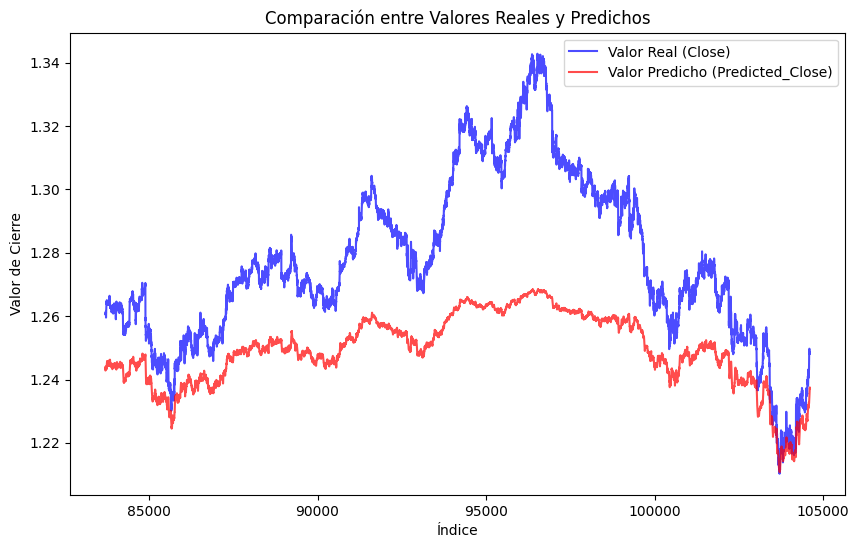

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='Valor Real (Close)', color='blue', alpha=0.7)
plt.plot(y_pred, label='Valor Predicho (Predicted_Close)', color='red', alpha=0.7)
plt.title('Comparación entre Valores Reales y Predichos')
plt.xlabel('Índice')
plt.ylabel('Valor de Cierre')
plt.legend()
plt.show()

In [ ]:
# Backtest
bt = Backtest(lstm_df_no_nan, GenericStrategy, cash=5000, commission=.000)
stats = bt.run()
print(stats)

Backtest.run:   0%|          | 0/20899 [00:00<?, ?it/s]

Start                                 83707.0
End                                  104606.0
Duration                              20899.0
Exposure Time [%]                     99.9378
Equity Final [$]                   5030.16899
Equity Peak [$]                     5185.5094
Return [%]                            0.60338
Buy & Hold Return [%]                -0.96539
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Alpha [%]                            -0.35736
Beta                                 -0.99518
Max. Drawdown [%]                     -8.5214
Avg. Drawdown [%]                    -0.44889
Max. Drawdown Duration                17829.0
Avg. Drawdown Duration                  463.4
# Trades                              18233.0
Win Rate [%]                         48.64257
Best Trade [%]                    

## **Estrategia 4**: Aprendizaje por refuerzo

### DQN

In [ ]:
dqn_df = df.copy()

dqn_df['SMA_50'] = dqn_df['Close'].rolling(window=50).mean()  # Media móvil simple de 50 periodos
dqn_df['SMA_20'] = dqn_df['Close'].rolling(window=20).mean()  # Media móvil simple de 20 periodos
dqn_df['EMA_50'] = dqn_df['Close'].ewm(span=50, adjust=False).mean()  # Media móvil exponencial de 50 periodos
dqn_df['MACD'] = dqn_df['Close'].ewm(span=12, adjust=False).mean() - dqn_df['Close'].ewm(span=26, adjust=False).mean()  # MACD
dqn_df['RSI'] = 100 - (100 / (1 + (dqn_df['Close'].diff(1).clip(lower=0).rolling(14).mean() / dqn_df['Close'].diff(1).clip(upper=0).abs().rolling(14).mean())))  # RSI
dqn_df['ADX'] = (dqn_df['High'] - dqn_df['Low']).rolling(window=14).mean()  # ADX simplificado
dqn_df['Bollinger_High'] = dqn_df['Close'].rolling(window=20).mean() + 2 * dqn_df['Close'].rolling(window=20).std()
dqn_df['Bollinger_Low'] = dqn_df['Close'].rolling(window=20).mean() - 2 * dqn_df['Close'].rolling(window=20).std()
dqn_df['Volatility'] = dqn_df['High'] - df['Low']

dqn_df.dropna(inplace=True)

In [ ]:
datetime_column = dqn_df['Time']
dqn_df.drop('Time', axis=1, inplace=True)

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class ForexTradingEnv(gym.Env):
    def __init__(self, data):
        super(ForexTradingEnv, self).__init__()

        self.data = data
        self.current_step = 0
        self.balance = 1000  # Capital inicial
        self.positions = 0   # Número de posiciones abiertas
        self.net_worth = self.balance
        self.buy_price = 0   # Precio de compra de la última posición
        self.total_profit = 0
        self.trade_history = []

        # Espacio de observación (ajusta según tus datos)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(len(self.data.columns),), dtype=np.float32
        )

        # Espacio de acción: 0 = Mantener, 1 = Comprar, 2 = Vender
        self.action_space = spaces.Discrete(3)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.balance = 1000
        self.positions = 0
        self.net_worth = self.balance
        self.buy_price = 0
        self.total_profit = 0
        self.trade_history = []

        observation = self.data.iloc[self.current_step].values.astype(np.float32)
        return observation, {}

    def step(self, action):
        self.current_step += 1

        if self.current_step >= len(self.data) - 1:
            self.current_step = len(self.data) - 2

        current_price = self.data.iloc[self.current_step]["Close"]
        reward = 0

        # Acción: Comprar
        if action == 1:
            if self.positions == 0:
                self.buy_price = current_price
                self.positions = 1
                self.trade_history.append(("buy", current_price))
                reward = 0  # No ganancia inmediata

        # Acción: Vender
        elif action == 2:
            if self.positions == 1:
                profit = current_price - self.buy_price
                self.total_profit += profit
                self.balance += profit
                self.positions = 0
                self.trade_history.append(("sell", current_price, profit))
                reward = profit  # La recompensa es la ganancia o pérdida obtenida

        # Actualizar el valor neto (balance + posiciones abiertas)
        self.net_worth = self.balance + self.positions * current_price

        # Finalización del episodio
        done = self.current_step >= len(self.data) - 1
        terminated = done
        truncated = False

        # Obtener la siguiente observación
        observation = self.data.iloc[self.current_step].values.astype(np.float32)
        info = {"net_worth": self.net_worth, "total_profit": self.total_profit}

        return observation, reward, terminated, truncated, info

    def render(self):
        print(f"Step: {self.current_step}, Balance: {self.balance}, Net Worth: {self.net_worth}, Total Profit: {self.total_profit}")

    def close(self):
        pass


In [ ]:
!pip install 'shimmy>=2.0'


In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
import pandas as pd

means = dqn_df.mean()
stds = dqn_df.std()

dqn_df = (dqn_df - dqn_df.mean()) / dqn_df.std()

train_size = int(len(dqn_df) * 0.8)
train_dqn_df = dqn_df.iloc[:train_size]
test_dqn_df = dqn_df.iloc[train_size:]

env = DummyVecEnv([lambda: ForexTradingEnv(train_dqn_df)])

dqn_model = DQN("MlpPolicy", env, verbose=1)
dqn_model.learn(total_timesteps=10000)

dqn_model.save("forex_trading_dqn")
print("Modelo DQN entrenado y guardado.")


Using cpu device
Modelo DQN entrenado y guardado.


In [ ]:
dqn_model = DQN.load("forex_trading_dqn")

test_env = DummyVecEnv([lambda: ForexTradingEnv(dqn_df)])

obs = test_env.reset()

dqn_signals = []

for step in range(len(dqn_df)):
    action, _ = dqn_model.predict(obs, deterministic=True)

    if action == 1:
        dqn_signals.append(1)
    elif action == 0:
        dqn_signals.append(0)
    else:
        dqn_signals.append(-1)

    obs, reward, done, info = test_env.step(action)

    if done[0]:
        break

dqn_df['Signal'] = dqn_signals

print(dqn_df.head())


        Open      High       Low     Close    Volume    SMA_50    SMA_20  \
49  0.531547  0.529174  0.529994  0.524481 -0.358823  0.563460  0.518469   
50  0.524524  0.524726  0.527702  0.526344 -0.253251  0.561412  0.518225   
51  0.526387  0.522143  0.524123  0.525771  0.169035  0.559471  0.518426   
52  0.525241  0.520708  0.524839  0.519321 -0.522836  0.557523  0.518734   
53  0.519364  0.514825  0.522691  0.517601 -0.652915  0.555524  0.518240   

      EMA_50      MACD       RSI       ADX  Bollinger_High  Bollinger_Low  \
49  0.554644 -0.843341  0.697964 -0.112205        0.509595       0.526974   
50  0.553537 -0.761914  0.664525 -0.194304        0.508748       0.527328   
51  0.552451 -0.693363  0.652789 -0.166938        0.509211       0.527269   
52  0.551155 -0.676680  0.049907 -0.232617        0.509348       0.527747   
53  0.549841 -0.667826  0.157473 -0.318821        0.508363       0.527738   

    Volatility  Signal  
49   -0.181078       1  
50   -0.384454       1  
51   

In [ ]:
copy = dqn_df.copy()

In [ ]:
# Desnormalización (revertir el proceso)
dqn_df = dqn_df * stds + means

In [ ]:

dqn_df.Signal = copy.Signal
dqn_df['Time'] = datetime_column
dqn_df['Time'] = pd.to_datetime(dqn_df['Time'])
dqn_df.head()

,ADX,Bollinger_High,Bollinger_Low,Close,EMA_50,High,Low,MACD,Open,RSI,SMA_20,SMA_50,Signal,Volatility,Volume,Time,Action
49,0.000855,1.322016,1.319486,1.32117,1.323268,1.32191,1.32113,-0.000678,1.32166,61.514683,1.320751,1.323890,1,0.00078,612.0,2020-11-11 21:15:00,Comprar
50,0.000812,1.321958,1.319510,1.32130,1.323191,1.32160,1.32097,-0.000613,1.32117,60.971787,1.320734,1.323748,1,0.00063,668.0,2020-11-11 21:30:00,Comprar
51,0.000826,1.321990,1.319506,1.32126,1.323115,1.32142,1.32072,-0.000558,1.32130,60.781250,1.320748,1.323612,1,0.00070,892.0,2020-11-11 21:45:00,Comprar
52,0.000792,1.321999,1.319540,1.32081,1.323025,1.32132,1.32077,-0.000545,1.32122,50.993377,1.320770,1.323476,1,0.00055,525.0,2020-11-11 22:00:00,Comprar
53,0.000747,1.321931,1.319539,1.32069,1.322933,1.32091,1.32062,-0.000538,1.32081,52.739726,1.320735,1.323337,1,0.00029,456.0,2020-11-11 22:15:00,Comprar


In [ ]:
action_map = {-1: 'Vender', 0: 'Esperar', 1: 'Comprar'}
dqn_df['Action'] = dqn_df['Signal'].map(action_map)


In [ ]:
dqn_df.head()

,ADX,Bollinger_High,Bollinger_Low,Close,EMA_50,High,Low,MACD,Open,RSI,SMA_20,SMA_50,Signal,Volatility,Volume,Time,Action
49,0.000855,1.322016,1.319486,1.32117,1.323268,1.32191,1.32113,-0.000678,1.32166,61.514683,1.320751,1.323890,1,0.00078,612.0,2020-11-11 21:15:00,Comprar
50,0.000812,1.321958,1.319510,1.32130,1.323191,1.32160,1.32097,-0.000613,1.32117,60.971787,1.320734,1.323748,1,0.00063,668.0,2020-11-11 21:30:00,Comprar
51,0.000826,1.321990,1.319506,1.32126,1.323115,1.32142,1.32072,-0.000558,1.32130,60.781250,1.320748,1.323612,1,0.00070,892.0,2020-11-11 21:45:00,Comprar
52,0.000792,1.321999,1.319540,1.32081,1.323025,1.32132,1.32077,-0.000545,1.32122,50.993377,1.320770,1.323476,1,0.00055,525.0,2020-11-11 22:00:00,Comprar
53,0.000747,1.321931,1.319539,1.32069,1.322933,1.32091,1.32062,-0.000538,1.32081,52.739726,1.320735,1.323337,1,0.00029,456.0,2020-11-11 22:15:00,Comprar


In [ ]:
dqn_df.Action.value_counts()

,count
Action,
Vender,55653
Comprar,37987
Esperar,10918


In [ ]:
# Backtest
bt = Backtest(dqn_df, GenericStrategy, cash=5000, commission=.000)
stats = bt.run()
print(stats)

Backtest.run:   0%|          | 0/104557 [00:00<?, ?it/s]

Start                                    49.0
End                                  104606.0
Duration                             104557.0
Exposure Time [%]                    99.99809
Equity Final [$]                     4662.115
Equity Peak [$]                     5544.2785
Return [%]                            -6.7577
Buy & Hold Return [%]                -5.50346
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Alpha [%]                            -9.15813
Beta                                 -0.43617
Max. Drawdown [%]                   -27.53929
Avg. Drawdown [%]                     -0.6133
Max. Drawdown Duration                58056.0
Avg. Drawdown Duration               815.9375
# Trades                              93637.0
Win Rate [%]                         49.58617
Best Trade [%]                    